**1. Downloading the Corpus and importing lib**



In [1]:
import nltk
import numpy as np
import pandas as pd
import re

from keras.preprocessing.sequence import skipgrams
from keras.layers import Dot, Input
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import plot_model
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('gutenberg')

from nltk.corpus import gutenberg
from nltk.corpus import stopwords
from pandas import DataFrame

# Load the Austen Corpus
austen = gutenberg.sents('austen-sense.txt') + gutenberg.sents('austen-emma.txt') + gutenberg.sents('austen-persuasion.txt')
print()
# Sanity Check
print('Sanity Checked:', len(austen))

Using TensorFlow backend.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package gutenberg to /root/nltk_data...
[nltk_data]   Unzipping corpora/gutenberg.zip.

Sanity Checked: 16498


**2. Preprocessing the Training Corpus**

In [2]:
# Initialise the Normalised corpus
normalized_corpus = []
# Load the stopwords for English
stop_words = stopwords.words('english')

def preprocessing(line, stop_words):
    
    # Takes in a list of words and nltk stop words.
    processed_Line = []
    for word in line:
        processedWord = word.lower()
        
        # Appends words to processed_Line if not in stop words, not blank, not punctuation and is alphanumeric
        if processedWord in stop_words or not processedWord.isalnum():
            continue
        processed_Line.append(processedWord)
    
    return processed_Line

# For each line in austen perform the word strip
for line in austen:
    processed_Line = preprocessing(line,stop_words)
    
    # If word is shorter than 2 words, skip it. 
    if len(processed_Line) > 2:
        normalized_corpus.append(processed_Line)
print("Actual austen length is:", len(austen))
print('Length of processed corpus:', len(normalized_corpus))
print('Processed line:', normalized_corpus[10])

Actual austen length is: 16498
Length of processed corpus: 13923
Processed line: ['therefore', 'succession', 'norland', 'estate', 'really', 'important', 'sisters', 'fortune', 'independent', 'might', 'arise', 'father', 'inheriting', 'property', 'could', 'small']


**3. Creating the Corpus Vocabulary and Preparing the Dataset.**

In [0]:
# creating index_word relationship
word2idx = {'<PADDING>': 0}   
idx2word = {}   #0:'<PADDING>'
sents_as_ids = []

for line in normalized_corpus:
  store_ids = []
  # if a word is seen before, update it to the store_ids list
  for each_word in line:
    if each_word is word2idx:
      store_ids.append(word2idx[each_word])
      print(store_ids)
    
    # if a word is not have seen before assign it to an id add it to the dict   
    count = len(word2idx)
    word2idx[each_word] = count
    idx2word[count] = each_word
    store_ids.append(count)
  sents_as_ids.append(store_ids)
    
# Set vocab size and embed size
vocab_size = len(word2idx) + 1
embed_size = 100

**Sanity check for Part A Question 3**




In [4]:
print(vocab_size)
print('Number of unique words:', len(word2idx))
print('\nSample word2idx: ', list(word2idx.items())[:10])
print('\nSample idx2word:', list(idx2word.items())[:10])
print('\nSample normalized corpus:', normalized_corpus[:3])
print('\nAbove sentences as a list of ids:' , sents_as_ids[:3])

10117
Number of unique words: 10116

Sample word2idx:  [('<PADDING>', 0), ('sense', 10109), ('sensibility', 10086), ('jane', 8829), ('austen', 8829), ('1811', 5), ('family', 10109), ('dashwood', 6119), ('long', 10109), ('settled', 10112)]

Sample idx2word: [(1, 'sense'), (2, 'sensibility'), (3, 'jane'), (4, 'austen'), (5, '1811'), (6, 'family'), (7, 'dashwood'), (8, 'long'), (9, 'settled'), (10, 'sussex')]

Sample normalized corpus: [['sense', 'sensibility', 'jane', 'austen', '1811'], ['family', 'dashwood', 'long', 'settled', 'sussex'], ['estate', 'large', 'residence', 'norland', 'park', 'centre', 'property', 'many', 'generations', 'lived', 'respectable', 'manner', 'engage', 'general', 'good', 'opinion', 'surrounding', 'acquaintance']]

Above sentences as a list of ids: [[1, 2, 3, 4, 5], [6, 7, 8, 9, 10], [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]]


**4. Generating training instances**

In [0]:
skip_grams = [skipgrams(sent, vocabulary_size=vocab_size, window_size=5) for sent in
sents_as_ids]

In [6]:
# view sample skip-grams
pairs, labels = skip_grams[0][0], skip_grams[0][1]
# This shows whether the two words occur together in the context window(size of which is set above) 
# 1 if they co-occur 0 
# We get all the times that a word occurs from the first sentence co-occurs with something 
# and only a handful (negative sampling) of the words it does not co-occur with 

for i in range(len(pairs)):
  print('({:s} ({:d}), {:s} ({:d})) -> {:d}'.format(
  # the first word and its index
  idx2word[pairs[i][0]], pairs[i][0],
  # the second word and its index
  idx2word[pairs[i][1]], pairs[i][1], 
  # the label
  labels[i]))

(sensibility (2), sense (1)) -> 1
(sense (1), deficient (1022)) -> 0
(austen (4), 1811 (5)) -> 1
(jane (3), hop (2089)) -> 0
(sensibility (2), austen (4)) -> 1
(austen (4), sensibility (2)) -> 1
(austen (4), becomingly (9656)) -> 0
(austen (4), solicitation (5286)) -> 0
(sensibility (2), jane (3)) -> 1
(sensibility (2), frightened (2555)) -> 0
(sense (1), remorse (5665)) -> 0
(jane (3), labour (3831)) -> 0
(1811 (5), remembering (3540)) -> 0
(austen (4), spectacles (7702)) -> 0
(1811 (5), sensibility (2)) -> 1
(sensibility (2), print (3042)) -> 0
(1811 (5), infirm (1803)) -> 0
(sensibility (2), sack (7721)) -> 0
(jane (3), sensibility (2)) -> 1
(jane (3), austen (4)) -> 1
(1811 (5), thankfulness (8783)) -> 0
(1811 (5), sense (1)) -> 1
(sensibility (2), engross (3317)) -> 0
(jane (3), answer (495)) -> 0
(1811 (5), spared (2192)) -> 0
(1811 (5), austen (4)) -> 1
(sense (1), austen (4)) -> 1
(sense (1), softener (3734)) -> 0
(sensibility (2), 1811 (5)) -> 1
(sense (1), 1811 (5)) -> 1
(jan

**5. Building the Skip-gram Neural Network Architecture**

In [0]:
from keras.layers import Dot, Input
from keras.layers.core import Dense, Reshape
from keras.layers.embeddings import Embedding
from keras.models import Model
from keras.utils import plot_model

A. The first step is to initialize and transform the first input using the following lines of code:

In [8]:
# The input is an array of target indices e.g. [2, 45, 7, 23,...9]
target_word = Input((1,), dtype='int32')

# feed the words into the model using the Keras <Embedding> layer. This is the hidden layer from whose weights we will get the word embeddings 
target_embedding = Embedding(vocab_size, embed_size, name='target_embed_layer',
embeddings_initializer='glorot_uniform',
input_length=1)(target_word)

# at this point, the input would of the shape (num_inputs x 1 x embed_size) and has to be flattened or reshaped into a (num_inputs x embed_size) tensor.
target_input = Reshape((embed_size, ))(target_embedding)


**B. Write similar code for the ‘context_word’ input.**

In [0]:
# repeat the same for the context word
context_word = Input((1,), dtype='int32')
context_embedding = Embedding(vocab_size, embed_size, name='context_embed_layer', \
embeddings_initializer='glorot_uniform', \
input_length=1)(context_word)
context_input = Reshape((embed_size, ))(context_embedding)

**C. Merge the inputs.**

In [0]:
merged_inputs = Dot(axes=-1, normalize=False)([target_input, context_input])

# **D & E and F. Pass the merged inputs into sigmoid activated layer, Initialize the model, Compile the Model**

In [11]:
label = Dense(1,activation='sigmoid')(merged_inputs)
model = Model(inputs=[target_word, context_word], outputs=[label])
model.compile(loss='mean_squared_error', optimizer='rmsprop')

**Sanity check**

In [12]:
print("Sanity Check")
model.summary()

Sanity Check
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
target_embed_layer (Embedding)  (None, 1, 100)       1011700     input_1[0][0]                    
__________________________________________________________________________________________________
context_embed_layer (Embedding) (None, 1, 100)       1011700     input_2[0][0]                    
_______________________________________________________________________________

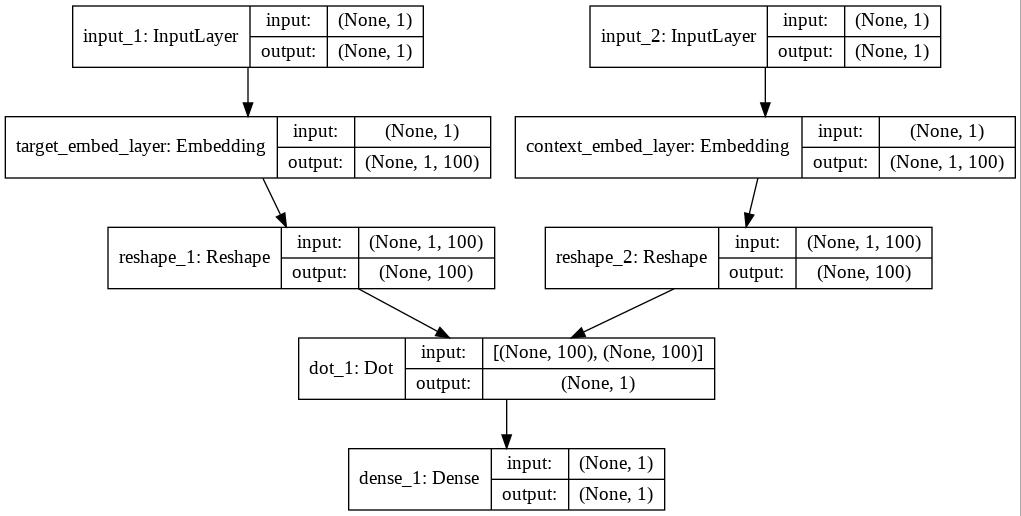

In [13]:
plot_model(model, to_file='skipgram_keras.jpg', show_shapes=True, show_layer_names=True,
rankdir='TB')

**6. Training the Model**

In [14]:
for epoch in range(1, 6):
  epoch_loss = 0
  # in each epoch, train all the sentences, one per iteration=> batch_size = num_sents
  for i, sent_examples in enumerate(skip_grams):
      target_wds = np.array([pair[0] for pair in sent_examples[0]], dtype='int32')
      context_wds = np.array([pair[1] for pair in sent_examples[0]], dtype='int32')
      labels = np.array(sent_examples[1], dtype='int32')
      X = [target_wds, context_wds]
      Y = labels
      if i % 5000 == 0: # after 5000 sentences i.e. 5000 iterations
        print('Processed %d sentences' %i)
      epoch_loss += model.train_on_batch(X, Y)
  print('Processed all %d sentences' %i)
  print('Epoch:', epoch, 'Loss:', epoch_loss, '\n')

Processed 0 sentences








Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 1 Loss: 3251.09830956161 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 2 Loss: 1831.3825360080227 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 3 Loss: 849.629506499803 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 4 Loss: 427.24687919966766 

Processed 0 sentences
Processed 5000 sentences
Processed 10000 sentences
Processed all 13922 sentences
Epoch: 5 Loss: 217.04885299797854 



**7. Getting the Word Embeddings**

In [0]:
# Get the word embeddings by getting the weights of the embed layer
word_embeddings = model.get_layer('target_embed_layer').get_weights()[0][1:]

In [16]:
#Sanity Check:
print(word_embeddings.shape)
print(DataFrame(word_embeddings, index=idx2word.values()).head(10))

(10116, 100)
                   0         1         2   ...        97        98        99
sense        0.013579 -0.008420  0.033331  ...  0.004342 -0.019719  0.013714
sensibility  0.003170 -0.005018  0.000417  ...  0.027859  0.025032 -0.022248
jane         0.035154 -0.006506  0.026858  ...  0.006656 -0.013060 -0.014342
austen      -0.012488  0.000138  0.038270  ...  0.023054 -0.000322 -0.009986
1811         0.018664 -0.001807  0.011979  ... -0.006927 -0.026784 -0.027096
family       0.008971  0.020014 -0.017384  ...  0.020149 -0.003998  0.010317
dashwood     0.002565  0.006985 -0.013858  ... -0.006122 -0.002581 -0.000911
long        -0.015415  0.018565  0.029012  ...  0.006482 -0.011379 -0.017190
settled     -0.028324 -0.013387  0.015893  ... -0.009528  0.034612 -0.014179
sussex      -0.005862 -0.017418  0.004699  ...  0.032625  0.013308 -0.029256

[10 rows x 100 columns]


**8. Measuring Similarity Between Word Pairs**

In [0]:
from sklearn.metrics.pairwise import cosine_similarity
similarity_matrix = cosine_similarity(word_embeddings)

In [18]:
#Check:
print(similarity_matrix.shape)

(10116, 10116)


**9. Exploring and Visualizing your Word Embeddings using t-SNE**

In [19]:
# A. Get the most similar words to the search items in the list below
search_terms = ['man', 'love', 'hatred', 'woman', 'wisdom', 'kindness', 'god', 'man', 'folly', 'fool']

# Get the 5 words most similar to the search terms
similar_words = {term: [idx2word[idx]
for idx in (-1 * similarity_matrix[word2idx[term]-1]).argsort()[1:6] + 1]
for term in search_terms}

print(similar_words)

{'man': ['depriving', 'banker', 'trouble', 'gammon', 'supplies'], 'love': ['kinds', 'chances', 'satisfactions', 'talkative', 'prodigy'], 'hatred': ['replete', 'airy', 'bravado', 'bragge', 'candidates'], 'woman': ['discomfited', 'resort', 'softening', 'nuncheon', 'presentation'], 'wisdom': ['suppositions', 'alienations', 'secondly', 'objected', 'springing'], 'kindness': ['cared', 'abominate', 'unfolding', 'confer', 'incomplete'], 'god': ['covet', 'dullest', 'interfere', 'official', 'lending'], 'folly': ['connivance', 'calculates', 'subordination', 'count', 'dreamt'], 'fool': ['violated', 'recantation', 'shedding', 'crowded', 'sensitive']}


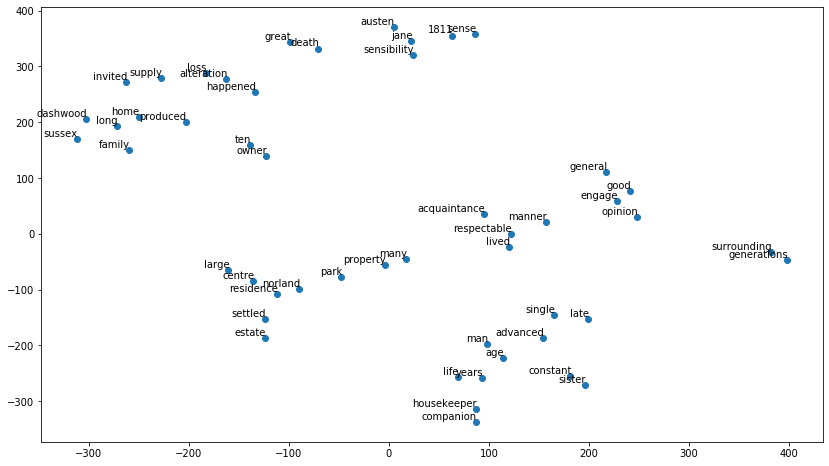

In [20]:
# B. Plot the words in the dictionary above using t-SNE
tsne = TSNE(perplexity=3, n_components=2, init='pca', n_iter=5000, method='exact')
np.set_printoptions(suppress=True)
plot_only = 50
T = tsne.fit_transform(word_embeddings[:plot_only, :])
labels = [idx2word[i+1] for i in range(plot_only)]
plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1])
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points', ha='right',
va='bottom')